In [3]:
import os
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sn; sn.set(font_scale=1.4)                                             
from tqdm import tqdm

In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [5]:
class_names = os.listdir('train')
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

In [47]:
def load_data():
    
    datasets = ['train', 'test']
    output = []
    
    
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (96,96)) 
                
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output


In [48]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  5%|▌         | 50/1000 [00:00<00:01, 497.55it/s]

Loading train


 18%|█▊        | 55/300 [00:00<00:00, 543.55it/s]

Loading test


100%|██████████| 300/300 [00:00<00:00, 505.61it/s]


In [8]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))


Number of training examples: 10000
Number of testing examples: 3000


In [18]:
METRICS = [
      'accuracy',
      
    ]

In [86]:
def plot_metrics(history):
    metrics =  ['loss', 'acc']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        else:
          plt.ylim([0,1])

    plt.legend()

Так как я больше NLP инженер и с CV задачами знаком слабо, то мною было принято решение не изобретать велосипед и прикрутить полносвязную сеть к уже готовой и обученной на датасете ImageNet, сети Xception. По собственным замерам, Xception показывает на данном датасете результаты лучшие чем ResNet и Inception на 15%.


In [56]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",  
    input_shape=(96, 96, 3),
    include_top=False,
)  
base_model.trainable = False


inputs = tf.keras.Input(shape=(96, 96, 3))

norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
x = norm_layer(inputs)
norm_layer.set_weights([mean, var])

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(2048)(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 96, 96, 3)         7         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [57]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [58]:
train_images.shape

(10000, 96, 96, 3)

In [59]:
hisory = model.fit(train_images, train_labels, batch_size=64, epochs=20, validation_data=(test_images, test_labels))

Epoch 1/20
157/157 [==============================] - 11s 70ms/step - loss: 0.6923 - accuracy: 0.7862 - val_loss: 0.7271 - val_accuracy: 0.7960
Epoch 2/20
157/157 [==============================] - 10s 67ms/step - loss: 0.4675 - accuracy: 0.8531 - val_loss: 0.5134 - val_accuracy: 0.8367
Epoch 3/20
157/157 [==============================] - 11s 67ms/step - loss: 0.3944 - accuracy: 0.8698 - val_loss: 0.5975 - val_accuracy: 0.8307
Epoch 4/20
157/157 [==============================] - 11s 69ms/step - loss: 0.3418 - accuracy: 0.8864 - val_loss: 0.7328 - val_accuracy: 0.7957
Epoch 5/20
157/157 [==============================] - 11s 70ms/step - loss: 0.3072 - accuracy: 0.9010 - val_loss: 0.5403 - val_accuracy: 0.8453
Epoch 6/20
157/157 [==============================] - 11s 71ms/step - loss: 0.2710 - accuracy: 0.9107 - val_loss: 0.5319 - val_accuracy: 0.8520
Epoch 7/20
157/157 [==============================] - 11s 70ms/step - loss: 0.2428 - accuracy: 0.9194 - val_loss: 0.5309 - val_accuracy:

In [63]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

По данному графику видно что модель достаточно хорошо разделяет классы и было принято решение использовать Transfer Learning и доучить данную модель вмести с классификатором который к ней был добавлен на нашем датасете


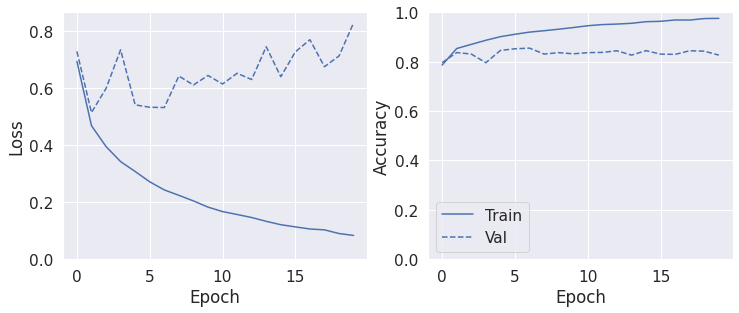

In [66]:
plot_metrics(hisory)

In [67]:
base_model.trainable = True
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 96, 96, 3)         7         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [70]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=1e-5), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [71]:
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
157/157 [==============================] - 41s 260ms/step - loss: 0.0549 - accuracy: 0.9836 - val_loss: 0.7187 - val_accuracy: 0.8553
Epoch 2/10
157/157 [==============================] - 39s 246ms/step - loss: 0.0180 - accuracy: 0.9963 - val_loss: 0.7518 - val_accuracy: 0.8640
Epoch 3/10
157/157 [==============================] - 40s 252ms/step - loss: 0.0085 - accuracy: 0.9985 - val_loss: 0.8133 - val_accuracy: 0.8633
Epoch 4/10
157/157 [==============================] - 39s 248ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.8408 - val_accuracy: 0.8667
Epoch 5/10
157/157 [==============================] - 39s 250ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.8949 - val_accuracy: 0.8727
Epoch 6/10
157/157 [==============================] - 39s 249ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.9136 - val_accuracy: 0.8747
Epoch 7/10
157/157 [==============================] - 39s 250ms/step - loss: 5.8765e-04 - accuracy: 0.9998 - val_loss: 0.9560 - va

Из данного графика видно что модель стала стабильнее и результаты немного улучшились


In [72]:
plot_metrics(history)

Задействуем техннику Pseudo labeling, так как у меня не большой объем GPU буффера, то я отобрал еще 10000 картинок, разметил нашей моделью и добавил в обучающую выборку


In [73]:
images = []  
i = 0
for file in tqdm(os.listdir('unlabeled')):
    if i < 10000:
                # Get the path name of the image
      img_path = os.path.join('unlabeled', file)
#     print(img_path) 
                # Open and resize the img
      if os.path.isfile(img_path):
          image = cv2.imread(img_path)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = cv2.resize(image, (96,96)) 
                
                # Append the image and its corresponding label to the output
          images.append(image)
          i += 1

100%|██████████| 100010/100010 [00:18<00:00, 5324.98it/s]


In [74]:
images = np.array(images, dtype = 'float32')

In [75]:
predictions = model.predict(images)


In [76]:
np.shape(predictions)

(10000, 10)

In [77]:
pred_labels = np.argmax(predictions, axis = 1)

In [78]:
type(pred_labels)

numpy.ndarray

In [79]:
new_train_images = np.concatenate([train_images, images])
new_train_labels = np.concatenate([train_labels, pred_labels])

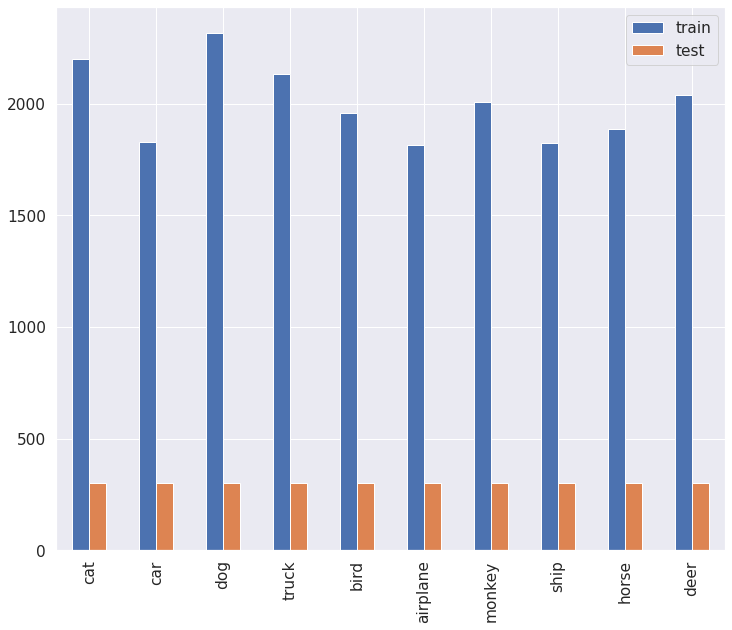

In [80]:
import pandas as pd

_, train_counts = np.unique(new_train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

Видно что теперь у нас соотношение объектов каждого класса в выборке изменилось


In [81]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=1e-5), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [82]:
history = model.fit(new_train_images, new_train_labels, batch_size=64, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
313/313 [==============================] - 77s 247ms/step - loss: 0.1013 - acc: 0.9614 - val_loss: 1.0256 - val_acc: 0.8790
Epoch 2/10
313/313 [==============================] - 76s 243ms/step - loss: 0.0379 - acc: 0.9863 - val_loss: 1.0759 - val_acc: 0.8760
Epoch 3/10
313/313 [==============================] - 76s 243ms/step - loss: 0.0185 - acc: 0.9938 - val_loss: 1.1070 - val_acc: 0.8770
Epoch 4/10
313/313 [==============================] - 76s 242ms/step - loss: 0.0100 - acc: 0.9969 - val_loss: 1.0989 - val_acc: 0.8793
Epoch 5/10
313/313 [==============================] - 76s 242ms/step - loss: 0.0063 - acc: 0.9980 - val_loss: 1.1470 - val_acc: 0.8760
Epoch 6/10
313/313 [==============================] - 76s 242ms/step - loss: 0.0036 - acc: 0.9991 - val_loss: 1.1885 - val_acc: 0.8850
Epoch 7/10
313/313 [==============================] - 76s 242ms/step - loss: 0.0034 - acc: 0.9992 - val_loss: 1.2662 - val_acc: 0.8810
Epoch 8/10
313/313 [==============================] - 7

Из графика ниже можно сделать вывод, что модель стала вести себя стабильнее + добавление новых данных помогло незначительно улучшить точность. В конечном итоге, если обладать большим объемом ГПУ то даже при данном подходе можно достичь точности >=90%


In [87]:
plot_metrics(history)

In [88]:
model.save('test_task_model.h5')